# **Install Libraries**

In [ ]:
# Install Pathway and Bokeh
!pip install pathway bokeh


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 13.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 2

# **Imports**

In [ ]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import push_notebook
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import pathway as pw


# **Load Dataset**

In [ ]:
# Upload CSV in Colab
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("Data shape:", df.shape)
df.head()


Saving dataset (1).csv to dataset (1).csv
Data shape: (18368, 12)


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


# **Explore Data**

ID                          int64
SystemCodeNumber           object
Capacity                    int64
Latitude                  float64
Longitude                 float64
Occupancy                   int64
VehicleType                object
TrafficConditionNearby     object
QueueLength                 int64
IsSpecialDay                int64
LastUpdatedDate            object
LastUpdatedTime            object
dtype: object
ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0
dtype: int64


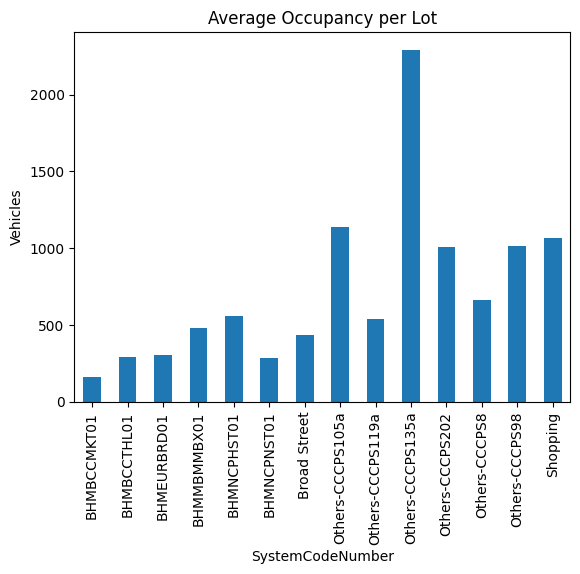

In [ ]:
print(df.dtypes)
print(df.isnull().sum())

# Plot average occupancy
avg_occ = df.groupby('SystemCodeNumber')['Occupancy'].mean()
avg_occ.plot(kind='bar')
plt.title("Average Occupancy per Lot")
plt.ylabel("Vehicles")
plt.show()

# **Model 1 – Baseline Linear Model**

In [ ]:
def baseline_model(df, alpha=1.5, base_price=10):
    prices = []
    current_price = base_price

    # Combine date and time into timestamp
    df['Timestamp'] = pd.to_datetime(
        df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
        format='%d-%m-%Y %H:%M:%S',
        dayfirst=True
    )

    for i, row in df.iterrows():
        # Check for zero capacity to avoid divide-by-zero
        if row['Capacity'] == 0:
            occupancy_ratio = 0
        else:
            occupancy_ratio = row['Occupancy'] / row['Capacity']

        # Compute new price
        current_price += alpha * occupancy_ratio
        current_price = np.clip(current_price, 5, 20)
        prices.append(current_price)

    df['BaselinePrice'] = prices
    return df

df_baseline = baseline_model(df.copy())
df_baseline[['Timestamp', 'SystemCodeNumber', 'BaselinePrice']].head()

,Timestamp,SystemCodeNumber,BaselinePrice
0,2016-10-04 07:59:00,BHMBCCMKT01,10.158579
1,2016-10-04 08:25:00,BHMBCCMKT01,10.324957
2,2016-10-04 08:59:00,BHMBCCMKT01,10.532929
3,2016-10-04 09:32:00,BHMBCCMKT01,10.811092
4,2016-10-04 09:59:00,BHMBCCMKT01,11.201040


# **Model 2 – Demand-Based Model**

In [ ]:
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5
}


# **Compute Demand & Price**

In [ ]:
import numpy as np
import pandas as pd

# Assuming df already loaded from CSV

# STEP 1 - Create Timestamp column
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S',
    dayfirst=True
)

# STEP 2 - Map TrafficConditionNearby to numeric
traffic_map = {'low': 1, 'medium': 2, 'high': 3}
df['TrafficNumeric'] = df['TrafficConditionNearby'].map(traffic_map)

# Vehicle weights dictionary
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5
}

# STEP 3 - Demand-based model
def demand_based_model(df,
                       alpha=2.0, beta=0.8, gamma=1.0,
                       delta=2.0, lambda_=0.5,
                       base_price=10):

    demands = []
    for i, row in df.iterrows():
        vehicle_type = str(row['VehicleType']).lower()
        weight = vehicle_weights.get(vehicle_type, 1.0)

        if row['Capacity'] == 0:
            occ_ratio = 0
        else:
            occ_ratio = row['Occupancy'] / row['Capacity']

        demand = (
            alpha * occ_ratio +
            beta * row['QueueLength'] -
            gamma * row['TrafficNumeric'] +
            delta * row['IsSpecialDay'] +
            weight
        )
        demands.append(demand)

    df['DemandRaw'] = demands

    # Normalize
    min_d = df['DemandRaw'].min()
    max_d = df['DemandRaw'].max()
    if max_d == min_d:
        df['DemandNorm'] = 0
    else:
        df['DemandNorm'] = (df['DemandRaw'] - min_d) / (max_d - min_d)

    # Compute price
    df['DemandPrice'] = base_price * (1 + lambda_ * df['DemandNorm'])
    df['DemandPrice'] = df['DemandPrice'].clip(lower=base_price * 0.5,
                                               upper=base_price * 2.0)
    return df

# STEP 4 - Run the model
df_demand = demand_based_model(df.copy())

# Show output
print(df_demand[['Timestamp', 'SystemCodeNumber', 'DemandPrice']].head())


            Timestamp SystemCodeNumber  DemandPrice
0 2016-10-04 07:59:00      BHMBCCMKT01    10.517318
1 2016-10-04 08:25:00      BHMBCCMKT01    10.520970
2 2016-10-04 08:59:00      BHMBCCMKT01    10.821344
3 2016-10-04 09:32:00      BHMBCCMKT01    10.854205
4 2016-10-04 09:59:00      BHMBCCMKT01    10.730976


# **Model 3 – Competitive Pricing**

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # meters
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)

    a = sin(dphi/2)**2 + cos(phi1) * cos(phi2) * sin(dlambda/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


# **Competitive Model Function**

In [ ]:
def competitive_model(df, base_price=10, eta=0.1, neighbor_radius=500):
    # Average price per parking lot
    avg_prices = df.groupby('SystemCodeNumber')['DemandPrice'].mean().to_dict()

    # Get unique lot locations
    lots = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first()

    competitive_prices = []

    for i, row in df.iterrows():
        current_lot = row['SystemCodeNumber']
        current_lat = row['Latitude']
        current_lon = row['Longitude']
        current_price = row['DemandPrice']

        # Find nearby lots
        nearby_prices = []
        for other_lot, other_row in lots.iterrows():
            if other_lot == current_lot:
                continue
            dist = haversine(current_lat, current_lon,
                             other_row['Latitude'],
                             other_row['Longitude'])
            if dist <= neighbor_radius:
                nearby_prices.append(avg_prices[other_lot])

        # If no nearby lots → keep current price
        if len(nearby_prices) == 0:
            competitive_prices.append(current_price)
            continue

        avg_nearby_price = np.mean(nearby_prices)

        # Prevent divide-by-zero
        if current_price == 0:
            adjustment = 1.0
        else:
            adjustment = 1 + eta * ((avg_nearby_price - current_price) / current_price)

        new_price = current_price * adjustment
        new_price = np.clip(new_price, base_price * 0.5, base_price * 2.0)

        competitive_prices.append(new_price)

    df['CompetitivePrice'] = competitive_prices
    return df

# Run the model
df_competitive = competitive_model(df_demand.copy())

# Show results
print(df_competitive[['Timestamp', 'SystemCodeNumber', 'CompetitivePrice']].head())

            Timestamp SystemCodeNumber  CompetitivePrice
0 2016-10-04 07:59:00      BHMBCCMKT01         10.631447
1 2016-10-04 08:25:00      BHMBCCMKT01         10.634733
2 2016-10-04 08:59:00      BHMBCCMKT01         10.905070
3 2016-10-04 09:32:00      BHMBCCMKT01         10.934645
4 2016-10-04 09:59:00      BHMBCCMKT01         10.823739


# **Visualization with Bokeh**

In [ ]:
output_notebook()

# Pick the first parking lot ID
lot_id = df_competitive['SystemCodeNumber'].unique()[0]

# Filter data for that lot
plot_df = df_competitive[df_competitive['SystemCodeNumber'] == lot_id]

# Create the figure
p = figure(title=f"Price Trends for Lot {lot_id}",
           x_axis_type="datetime",
           width=900, height=300)

# Plot each pricing line
if 'BaselinePrice' in plot_df.columns:
    p.line(plot_df['Timestamp'],
           plot_df['BaselinePrice'],
           color='blue',
           legend_label='Baseline Price')

if 'DemandPrice' in plot_df.columns:
    p.line(plot_df['Timestamp'],
           plot_df['DemandPrice'],
           color='green',
           legend_label='Demand-Based Price')

if 'CompetitivePrice' in plot_df.columns:
    p.line(plot_df['Timestamp'],
           plot_df['CompetitivePrice'],
           color='red',
           legend_label='Competitive Price')

p.legend.location = "top_left"
p.xaxis.major_label_orientation = np.pi/4
p.yaxis.axis_label = "Price ($)"

show(p)

# **Real-Time Streaming with Pathway**

In [ ]:
import pandas as pd
import numpy as np

# Read CSV
df = pd.read_csv("/content/dataset (1).csv")

# Add timestamp
df["Timestamp"] = pd.to_datetime(
    df["LastUpdatedDate"] + " " + df["LastUpdatedTime"],
    format="%d-%m-%Y %H:%M:%S"
)

# Compute baseline price
alpha = 1.5
base_price = 10
df["BaselinePrice"] = base_price + alpha * (df["Occupancy"] / df["Capacity"])
df["BaselinePrice"] = df["BaselinePrice"].clip(5, 20)

# Save only necessary columns
df_out = df[["Timestamp", "SystemCodeNumber", "BaselinePrice"]]

# Save to CSV
df_out.to_csv("/content/result.csv", index=False)

# Download
from google.colab import files
files.download("/content/result.csv")
